# Using quantile regression for point / interval estimation

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor


## Build data

In [59]:
np.random.seed(32)
x = np.linspace(1, 15, 1000)
y = x/2 + np.sin(x) + 0.005*x**2*np.random.randn(len(x))

# machine-learning like
X = x.reshape((len(x),1))

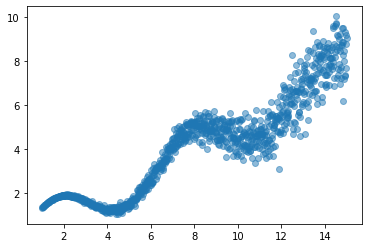

In [60]:
plt.scatter(x, y, alpha=0.5)
plt.show()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Baseline model

In [62]:
baseline = LGBMRegressor(random_state=2)
baseline.fit(X_train, y_train)

LGBMRegressor(random_state=2)

R2: 0.9448078744016933


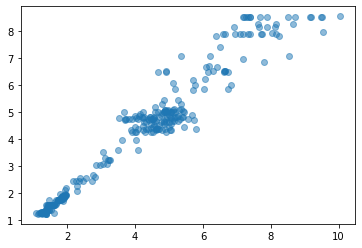

In [63]:
y_pred = baseline.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)
print("R2:", r2_score(y_test, y_pred))
plt.show()

## Create quantile-wise models

In [64]:
dq = 0.05
quantiles = np.arange(dq, 1, dq).round(2)
quantiles

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [65]:
model_dict = {q: LGBMRegressor(objective='quantile', metric='quantile', 
                               alpha=q, random_state=int(10*q), reg_alpha=2, reg_lambda=2)
             for q in quantiles}

In [66]:
for q in quantiles:
    model_dict[q].fit(X_train, y_train)

In [67]:
X_test_ordered = np.sort(X_test, axis=0)

### Plot median and quantiles 10 and 90

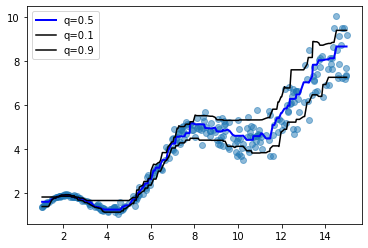

In [68]:
plt.scatter(X_test, y_test, alpha=0.5)
plt.plot(X_test_ordered, model_dict[0.5].predict(X_test_ordered), label='q=0.5', color='blue', lw=2)
plt.plot(X_test_ordered, model_dict[0.1].predict(X_test_ordered), label='q=0.1', color='black')
plt.plot(X_test_ordered, model_dict[0.90].predict(X_test_ordered), label='q=0.9', color='black')
plt.legend()
plt.show()

# Use quantiles to build means and standard deviations

Let $f_q: \mathcal X \to \mathcal Y$ be the quantile regression function for quantile $q$.


For any given $x$, what is the *mean* predicted value? 

For a random variable $Z$, letting $F(z) := \mathbb P(Z \leq z)$ be its CDF,

$$\begin{align*}
\mathbb E[Z] &= \int_{-\infty}^\infty z dF(z) = \int_0^1 F^{-1}(q) \; dq\\
             &= \int_0^1 g(q) \; dq
\end{align*}$$

where $g(q) \equiv F^{-1}(q)$ is the so-called *quantile function*.

This means we can calculate a mean by simply approximating the integral of the quantile function:

$$\mathbb E[Z] = \int_0^1 g(q) \; dq \approx \sum_{i=1}^N g(q_i) \Delta q$$

We have $g(q_i)$ - we can calculate it via the functions we just trained. It is the sum of predicted values times the difference in quantiles.

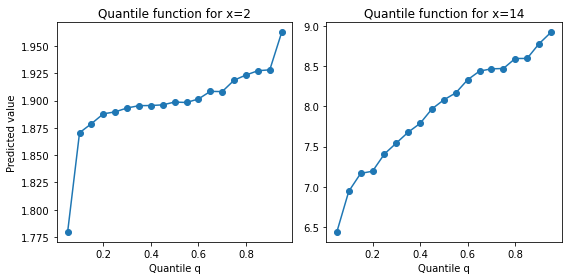

In [69]:
fig, ax =  plt.subplots(ncols=2, figsize=(8,4))
x = 2
y = [model_dict[q].predict(np.array([[x]]))[0] for q in quantiles]
ax[0].plot(quantiles, y, marker='o')
ax[0].set_xlabel("Quantile q")
ax[0].set_ylabel("Predicted value")
ax[0].set_title(f"Quantile function for {x=}")

x = 14
y = [model_dict[q].predict(np.array([[x]]))[0] for q in quantiles]
ax[1].plot(quantiles, y, marker='o')
ax[1].set_xlabel("Quantile q")
#ax[1].set_ylabel("Predicted value")
ax[1].set_title(f"Quantile function for {x=}")

plt.tight_layout()
plt.show()

OBS: this needs to be regularized so that quantiles are monotonic. We do this below:

In [70]:
def predict_mean(X, model_dict):
    quantiles = sorted(list(model_dict.keys()))
    dq = quantiles[1] - quantiles[0] 

    y = np.array([model_dict[q].predict(X) for q in quantiles])

    # regularize so that quantiles are monotonic
    y = np.array([np.maximum(el, np.pad(el, 1, mode='edge')[:-2]) for el in y.T]).T
    
    return np.sum(y, axis=0) * dq

In [71]:
y = predict_mean(X_test_ordered, model_dict)

R2: 0.9482445114073181


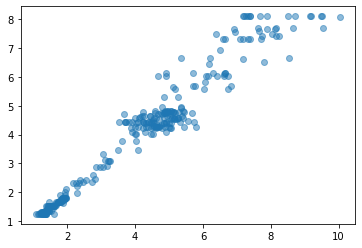

In [72]:
y_pred = predict_mean(X_test, model_dict)
plt.scatter(y_test, y_pred, alpha=0.5)
print("R2:", r2_score(y_test, y_pred))
plt.show()

Similar performance to original model

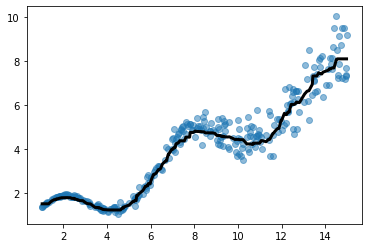

In [73]:
plt.plot(X_test_ordered, y, lw=3, color='black')
plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

The same argument can be used to calculate a *standard deviation* for predictions:

$$\mathrm{Var}\, Z = \sqrt{\int_0^1 g^2(q) \; dq - \left(\int_0^1 g(q) \; dq \right)^2}$$

In [74]:
def predict_mean_and_std(X, model_dict):
    quantiles = sorted(list(model_dict.keys()))
    dq = quantiles[1] - quantiles[0]

    y = np.array([model_dict[q].predict(X) for q in quantiles])

    # regularize so that quantiles are monotonic
    y = np.array([np.maximum(el, np.pad(el, 1, mode='edge')[:-2]) for el in y.T]).T
    
    mean    = np.sum(y, axis=0) * dq
    squared = np.sum(y**2, axis=0) * dq

    return mean, np.sqrt(squared - mean**2)

In [75]:
y, sigma = predict_mean_and_std(X_test_ordered, model_dict)

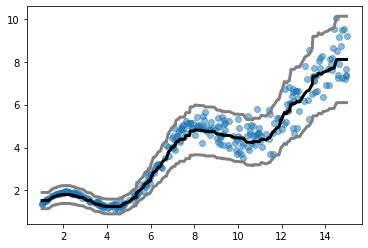

In [76]:
plt.plot(X_test_ordered, y, lw=3, color='black')
plt.plot(X_test_ordered, y+sigma, lw=3, color='grey')
plt.plot(X_test_ordered, y-sigma, lw=3, color='grey')

plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

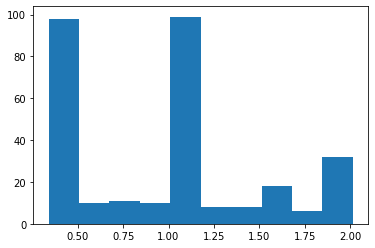

In [77]:
plt.hist(sigma)
plt.show()

# Make this into a class

In [78]:
from tqdm.notebook import tqdm

class LGBMQuantileRegressor:
    
    def __init__(self, 
                 **kwargs):
        
        self.dq = 0.05
        self.quantiles = np.arange(self.dq, 1, self.dq).round(2)
        self.lgbm_params = kwargs
        self.model_dict = self._build_models()

    def _build_models(self):
        return {q: LGBMRegressor(objective='quantile', metric='quantile', 
                                 alpha=q, random_state=int(100*q),
                                 **self.lgbm_params)
             for q in quantiles}
    
    def _regularize_quantile_prediction(self, y):
        """regularize so that quantiles are monotonic"""
        return np.array([np.maximum(el, np.pad(el, 1, mode='edge')[:-2]) for el in y.T]).T
    
    def fit(self, X, y):
        for q in tqdm(quantiles):
            self.model_dict[q].fit(X, y)
    
    def predict_quantile(self, X, q):
        return self.model_dict[q].predict(X)
    
    def predict_mean(self, X):

        y = np.array([self.model_dict[q].predict(X) for q in self.quantiles])
        y = self._regularize_quantile_prediction(y)

        return np.sum(y, axis=0) * self.dq
    
    def predict_mean_and_std(self, X):

        y = np.array([self.model_dict[q].predict(X) for q in self.quantiles])
        y = self._regularize_quantile_prediction(y)
        
        mean    = np.sum(y, axis=0) * self.dq
        squared = np.sum(y**2, axis=0) * self.dq

        return mean, np.sqrt(squared - mean**2)

In [79]:
model = LGBMQuantileRegressor(reg_alpha=2, reg_lambda=2)
model.fit(X_train, y_train)

  0%|          | 0/19 [00:00<?, ?it/s]

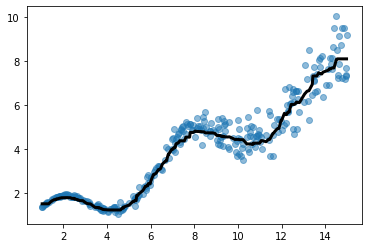

In [80]:
y = model.predict_mean(X_test_ordered)

plt.plot(X_test_ordered, y, lw=3, color='black')
plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

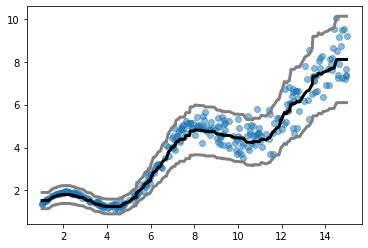

In [81]:
y, sigma = model.predict_mean_and_std(X_test_ordered)

plt.plot(X_test_ordered, y, lw=3, color='black')
plt.plot(X_test_ordered, y+sigma, lw=3, color='grey')
plt.plot(X_test_ordered, y-sigma, lw=3, color='grey')

plt.scatter(X_test, y_test, alpha=0.5)
plt.show()

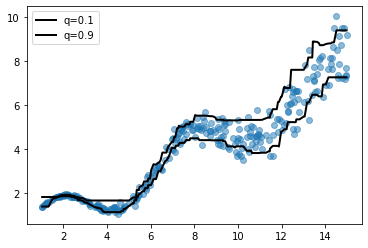

In [82]:
y = model.predict_quantile(X_test_ordered, q=0.1)
plt.plot(X_test_ordered, y, lw=2, color='black', label='q=0.1')

y = model.predict_quantile(X_test_ordered, q=0.9)
plt.plot(X_test_ordered, y, lw=2, color='black', label='q=0.9')

plt.scatter(X_test, y_test, alpha=0.5)
plt.legend()
plt.show()

#### For more features

In [83]:
X, y = make_regression(n_samples=10000, n_features=20, n_informative=10)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

> Baseline model:

In [85]:
baseline = LGBMRegressor(random_state=2)
baseline.fit(X_train, y_train)

LGBMRegressor(random_state=2)

R2: 0.9807785607378018


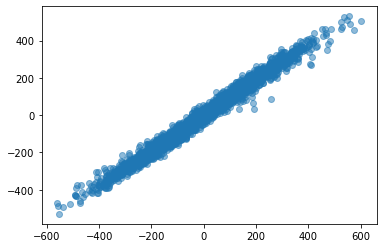

In [86]:
plt.scatter(y_test, baseline.predict(X_test), alpha=0.5)
print("R2:", r2_score(y_test, baseline.predict(X_test)))
plt.show()

> We expect a pretty performant model

In [87]:
model = LGBMQuantileRegressor()

In [88]:
model.fit(X_train, y_train)

  0%|          | 0/19 [00:00<?, ?it/s]

In [89]:
y_pred, std = model.predict_mean_and_std(X_test)

R2: 0.9326630066540902


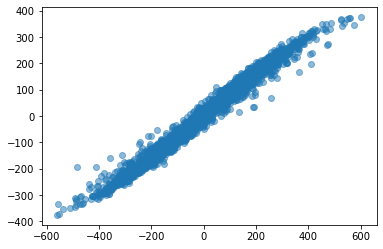

In [90]:
plt.scatter(y_test, y_pred, alpha=0.5)
print("R2:", r2_score(y_test, y_pred))
plt.show()

For some bloody reason this performs worse than the original one.

Comparing some points:

In [91]:
i = 0
print(f"Real value: {round(y_test[i],2)}")
print(f"Prediction: {round(y_pred[i],2)} +/- {round(std[i], 2)}")

Real value: 132.09
Prediction: 122.67 +/- 62.47


In [92]:
i = 2
print(f"Real value: {round(y_test[i],2)}")
print(f"Prediction: {round(y_pred[i],2)} +/- {round(std[i], 2)}")

Real value: 90.05
Prediction: 76.84 +/- 55.1


In [93]:
i = 3
print(f"Real value: {round(y_test[i],2)}")
print(f"Prediction: {round(y_pred[i],2)} +/- {round(std[i], 2)}")

Real value: -258.81
Prediction: -203.59 +/- 76.63


In [94]:
i = 5
print(f"Real value: {round(y_test[i],2)}")
print(f"Prediction: {round(y_pred[i],2)} +/- {round(std[i], 2)}")

Real value: -145.9
Prediction: -137.87 +/- 55.03


In [95]:
df = pd.DataFrame({
    'real': y_test,
    'prediction': y_pred,
    'std': std
})

In [96]:
df['difference'] = np.abs(df['real'] - df['prediction'])
df = df.sort_values('difference')

In [97]:
df['real'].describe()

count    3000.000000
mean       -4.192026
std       180.760495
min      -561.536244
25%      -129.855609
50%        -5.352434
75%       123.089383
max       602.155119
Name: real, dtype: float64

We have points ranging from ~-600 to +600

<AxesSubplot:xlabel='difference', ylabel='std'>

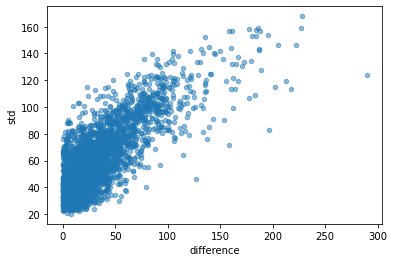

In [98]:
df.plot.scatter(x='difference', y='std', alpha=0.5)

# Building a quantile regressor for classification models

Although quantile regression is a regression model, we can use it to infer how much we trust the probabilities predicted by a classification model. 

Basically, we create a surrogate quantile regression model on the outputs of the classification model. We also add noise to the dataset as perturbations and calculate predictions, in order to simulate neighbours.

In [99]:
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.calibration import CalibrationDisplay

In [100]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_cols = X.columns
y.value_counts(normalize=True).round(2)

1    0.63
0    0.37
Name: target, dtype: float64

### Important!
For this to work, your data **needs to be normalized**

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_cols)

X_test = scaler.transform(X_test)

In [102]:
base_model = LGBMClassifier(random_state=2, max_depth=4)
base_model.fit(X_train, y_train)

LGBMClassifier(max_depth=4, random_state=2)

In [104]:
roc_auc_score(y_test, base_model.predict_proba(X_test)[:,1])

0.9926985981308412

We now introduce perturbations: we will slightly affect all features with some Gaussian noise to expand our data

In [105]:
max_noise = 50
eps = 0.05
np.random.seed(1)
noisy_copies = pd.concat(
    [X_train] + [X_train + eps*np.random.randn(*X_train.shape) for seed in range(max_noise)]
)

# create score predictions - these will be fit
noisy_scores = base_model.predict_proba(noisy_copies)[:,1]

In [106]:
surrog = LGBMQuantileRegressor()
surrog.fit(noisy_copies, noisy_scores)

  0%|          | 0/19 [00:00<?, ?it/s]

In [107]:
y_probs_mean, std = surrog.predict_mean_and_std(X_test)

Does the surrogate mean model perform similarly?

In [108]:
roc_auc_score(y_test, y_probs_mean)

0.9912383177570093

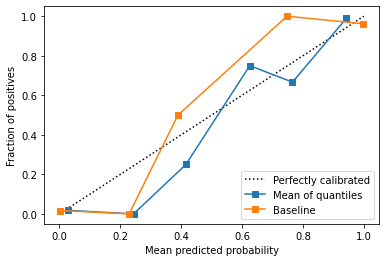

In [114]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_test, y_probs_mean, n_bins=6, ax=ax, name='Mean of quantiles')
CalibrationDisplay.from_estimator(base_model, X_test, y_test, n_bins=6, ax=ax, name='Baseline')

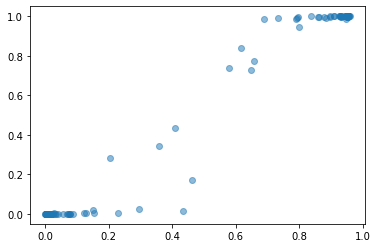

In [110]:
plt.scatter(y_probs_mean, base_model.predict_proba(X_test)[:,1], alpha=0.5)

This is close to the $\sqrt{p(1-p)}$ standard deviation we would expect from a binary model.

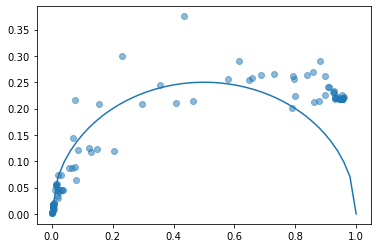

In [111]:
plt.scatter(surrog.predict_mean(X_test), std, alpha=0.5)
p = np.linspace(0,1)
plt.plot(p, 0.5* np.sqrt(p*(1-p)))